# SEIR forecast (prototype 2)

In [51]:
# tools needed
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import matplotlib.pyplot as plt

In [52]:
# reading the file
dengue_cases = pd.read_csv('cleaned_dengue_data.csv')
dengue_cases1 = dengue_cases.copy()

### S, E, I, R Formulation from Given Data
- The SEIR model requires 'S', 'E', 'I', 'R' columns.
- We will create these from the available data.

In [53]:
# I (Infected): The number of new cases per month is a good proxy for the infected population.
dengue_cases1['I'] = dengue_cases1['New_cases']

# N (Total Population): We can use the 'Total_Population' column from the data.
N = dengue_cases1['Total_Population'].iloc[0]

# R (Recovered): The cumulative number of cases is a good proxy for the recovered population.
# We'll use the 'Total_cases' column directly.
dengue_cases1['R'] = dengue_cases1['Total_cases']

# E (Exposed): The number of exposed individuals is tricky to get from raw data.
# A simple, reasonable assumption is that exposed individuals become infected in the next time step.
# We will use the 'New_cases' from the previous month as an estimate for 'E' for the current month.
# The .shift(1) method moves the 'New_cases' column down by one row.
# We fill the first value with 0 as there is no previous month.
dengue_cases1['E'] = dengue_cases1['New_cases'].shift(1).fillna(0)

# S (Susceptible): This is the remaining population that has not been infected, exposed, or recovered.
# S = N - E - I - R
dengue_cases1['S'] = N - dengue_cases1['E'] - dengue_cases1['I'] - dengue_cases1['R']

# The SEIR model assumes a constant population, so we will use the first value for N
# throughout the simulation.
dengue_cases1['N_model'] = N

### SEIR model 

In [ ]:
# --- SEIR model code ---
def seir_model(y, t, beta, sigma, gamma, N):
    """
    This function defines the system of ordinary differential equations (ODEs)
    for the SEIR model.

    y: A list containing the current values of S, E, I, and R.
    t: The current time.
    beta: The infection rate.
    sigma: The incubation rate.
    gamma: The recovery rate.
    N: The total population.
    """
    S, E, I, R = y
    dS_dt = -beta * S * I / N
    dE_dt = (beta * S * I / N) - (sigma * E)
    dI_dt = (sigma * E) - (gamma * I)
    dR_dt = gamma * I

    return [dS_dt, dE_dt, dI_dt, dR_dt]

# Set Parameters and Initial Conditions
# Get the total population from the first row of your data.
N = dengue_cases1['N_model'].iloc[0]

# Get the initial conditions for the forecast from the last row of your data.
last_row = dengue_cases1.iloc[-1]
S0 = last_row['S']
E0 = last_row['E']
I0 = last_row['I']
R0 = last_row['R']
y0 = [S0, E0, I0, R0]

# SEIR model parameters
beta = 0.5  # Infection rate
sigma = 1/5  # Incubation rate (1/incubation period, e.g., 5 days)
gamma = 1/10 # Recovery rate (1/infectious period, e.g., 10 days)

# Initial conditions for the model
y0 = [S0, E0, I0, R0]

# A grid of time points (in days)
t_forecast = np.linspace(0, 100, 100) # Simulate for 100 days

# --- 3. Run the Simulation ---
# The odeint function solves the differential equations over the time grid.
solution = odeint(seir_model, y0, t_forecast, args=(beta, sigma, gamma, N))
S, E, I, R = solution.T # Transpose the solution to get S, E, I, R as separate arrays

dengue_cases1[['Year', 'Month_Num', 'S', 'E', 'I', 'R']].to_csv('seir-forecast.csv')

### Forecast visualization

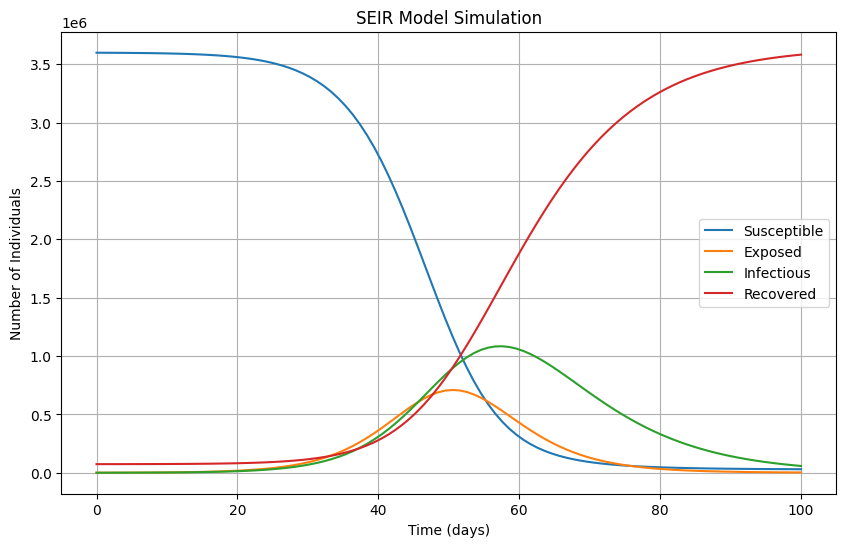

In [55]:
# --- Plot the Results ---
plt.figure(figsize=(10, 6))
plt.plot(t_forecast, S, label='Susceptible')
plt.plot(t_forecast, E, label='Exposed')
plt.plot(t_forecast, I, label='Infectious')
plt.plot(t_forecast, R, label='Recovered')
plt.xlabel('Time (days)')
plt.ylabel('Number of Individuals')
plt.title('SEIR Model Simulation')
plt.legend()
plt.grid(True)
plt.show()